# import rebound package 

In [1]:
import rebound
import datetime, julian
import numpy as np
import pandas as pd
from numpy import deg2rad, rad2deg
import progressbar
import time as tm

# build model

In [2]:
# date
date = "2021-01-01 00:00"
date_info = datetime.datetime.strptime(date,"%Y-%m-%d %H:%M")
MJD_model = julian.to_jd(date_info,fmt='mjd')

In [3]:
# rebound simulation
sim = rebound.Simulation()
sim.add('Geocenter',date = date)
sim.add('Luna')
sim.add('Sun')
print(f'{sim.units}')

Searching NASA Horizons for 'Geocenter'... Found: Earth (399).
Searching NASA Horizons for 'Luna'... Found: Moon (301).
Searching NASA Horizons for 'Sun'... Found: Sun (10).
{'length': 'au', 'mass': 'msun', 'time': 'yr2pi'}


In [4]:
earth = sim.particles[0]
moon = sim.particles[1]
moon_orbit = moon.calculate_orbit(primary=sim.particles[0])
sun = sim.particles[2]
sun_orbit = sun.calculate_orbit(primary=sim.particles[0])
print(moon_orbit,sun_orbit)

<rebound.Orbit instance, a=0.0025812439954974228 e=0.037521099070722715 inc=0.09154112040430387 Omega=1.3896905629985068 omega=2.3802522122941214 f=-1.63094188901329> <rebound.Orbit instance, a=0.9991716366722033 e=0.015930114396028518 inc=5.0015549439556286e-05 Omega=-2.6495341630882803 omega=1.2982011430043219 f=-0.03627589638314466>


# insert new TP

In [5]:
# TESS, km, deg
TP = {'a':2.424462130465623E+05, 'e':6.732154033321741E-01, 
      'inc':2.444076719703449E+01, 'Omega':1.593128966569460E+02,
      'omega':1.154918686689095E+02, 'M':2.106057280027349E+01
     }
# TESS, AU, rad
AU = 149597870.7 #km
TP['a'] /= AU
sim.add(primary=earth,a=TP['a'],e=TP['e'],inc=deg2rad(TP['inc']),
        Omega=deg2rad(TP['Omega']),omega=deg2rad(TP['omega']),
        M=deg2rad(TP['M']))
# add particle
TESS = sim.particles[-1]
TESS_orbit = TESS.calculate_orbit(primary=sim.particles[0])
print(f'Moon=\n{moon_orbit}')
print(f'TESS=\n{TESS_orbit}')
# save to binary setup file
simfile = f"CislunarSun_TESS_{MJD_model}.bin"
sim.save(simfile)

Moon=
<rebound.Orbit instance, a=0.0025812439954974228 e=0.037521099070722715 inc=0.09154112040430387 Omega=1.3896905629985068 omega=2.3802522122941214 f=-1.63094188901329>
TESS=
<rebound.Orbit instance, a=0.001620652833573852 e=0.6732154033321679 inc=0.42657185930167696 Omega=2.7805345875531593 omega=2.0157133675533974 f=-4.634717864256814>


In [6]:
fig = rebound.OrbitPlot(sim, unitlabel="[AU]")

# propagation

outupt interms of $\textbf{(AU, rad)}$

## ias15

In [7]:
# load sim binary
sim = rebound.Simulation(simfile)
sim.integrator = 'ias15'
sim.dt = 0.0001
sim.ri_ias15.epsilon = 1e-8 # control accuracy for ias15
print(f'dt = {sim.dt/(2*np.pi)*365.25*24*60} min')
print(f'ias15 accuracy = {sim.ri_ias15.epsilon}')

dt = 8.370913386861327 min
ias15 accuracy = 1e-08


In [8]:
Noutputs = 1000
Long_term_year = 30/365.25 # 1 year is 1 year on Earth, in rebound 365.25 days
year = 2.*np.pi # One year in units where G=1
times = np.linspace(0.,Long_term_year*year, Noutputs)
MJD,a,e,inc,Omega,omega,M = np.zeros((7,Noutputs))
Energy = np.zeros(Noutputs)
x,y,z,vx,vy,vz = np.zeros((6,Noutputs))
print(f'model MJD = {MJD_model}')

model MJD = 59215.0


In [9]:
# conduct integration
sim.move_to_com()  # We always move to the center of momentum frame 
ps = sim.particles # ps is now an array of pointers and will change as the simulation runs
bar = progressbar.ProgressBar(max_value=max(times/year*365.25)) # progress bar
for i,time in enumerate(times):
    bar.update(time/year*365.25) # updating bar
    sim.integrate(time)
    # get orbit element from numerical integration in radians with Sun
    MJD[i] = MJD_model + time/year*365.25
    # orbit parameters
    orbit = ps[-1].calculate_orbit(primary=sim.particles[0])
    a[i],e[i],inc[i] = orbit.a, orbit.e, orbit.inc
    Omega[i],omega[i],M[i] = orbit.Omega, orbit.omega, orbit.M
    Energy[i] = sim.calculate_energy()
    # cartesian parameters
    ptc = ps[-1]
    x[i],y[i],z[i] = ptc.x, ptc.y, ptc.z
    vx[i],vy[i],vz[i] = ptc.vx, ptc.vy, ptc.vz

N/A% (0 of 30.0) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

In [10]:
# write trajectory
oe_filename=f"traj_{sim.integrator}_oe.csv"
oe_array = np.column_stack((MJD,a,e,inc,Omega,omega,M))
pd.DataFrame(oe_array).to_csv(oe_filename,header=None,index=None)
# write cartesian
rv_filename=f"traj_{sim.integrator}_rv.csv"
rv_array = np.column_stack((MJD,x,y,z,vx,vy,vz))
pd.DataFrame(rv_array).to_csv(rv_filename,header=None,index=None)

# visualization

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

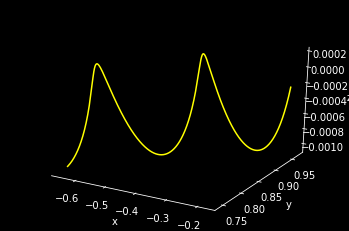

In [12]:
# trajectory
plt.style.use('dark_background')
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.grid(False)
ax.plot3D(x, y, z, 'yellow')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# make the panes black
ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))

2.117582368135751e-22


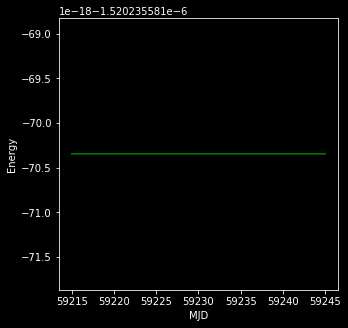

In [13]:
# energy
plt.style.use('dark_background')
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
plt.plot(MJD, Energy, 'green')
ax.set_xlabel('MJD')
ax.set_ylabel('Energy')

print(Energy[-1]-Energy[0])

## mercurius

In [14]:
# load sim binary
sim = rebound.Simulation(simfile)
sim.integrator = 'mercurius'
sim.dt = 0.0001
sim.ri_ias15.epsilon = 1e-8 # control accuracy for ias15
print(f'dt = {sim.dt/(2*np.pi)*365.25*24*60} min')
print(f'ias15 accuracy = {sim.ri_ias15.epsilon}')

dt = 8.370913386861327 min
ias15 accuracy = 1e-08


In [15]:
Noutputs = 1000
Long_term_year = 30/365.25 # 1 year is 1 year on Earth, in rebound 365.25 days
year = 2.*np.pi # One year in units where G=1
times = np.linspace(0.,Long_term_year*year, Noutputs)
MJD,a,e,inc,Omega,omega,M = np.zeros((7,Noutputs))
Energy = np.zeros(Noutputs)
x,y,z,vx,vy,vz = np.zeros((6,Noutputs))
print(f'model MJD = {MJD_model}')

model MJD = 59215.0


In [16]:
# conduct integration
sim.move_to_com()  # We always move to the center of momentum frame 
ps = sim.particles # ps is now an array of pointers and will change as the simulation runs
bar = progressbar.ProgressBar(max_value=max(times/year*365.25)) # progress bar
for i,time in enumerate(times):
    bar.update(time/year*365.25) # updating bar
    sim.integrate(time)
    # get orbit element from numerical integration in radians with Sun
    MJD[i] = MJD_model + time/year*365.25
    # orbit parameters
    orbit = ps[-1].calculate_orbit(primary=sim.particles[0])
    a[i],e[i],inc[i] = orbit.a, orbit.e, orbit.inc
    Omega[i],omega[i],M[i] = orbit.Omega, orbit.omega, orbit.M
    Energy[i] = sim.calculate_energy()
    # cartesian parameters
    ptc = ps[-1]
    x[i],y[i],z[i] = ptc.x, ptc.y, ptc.z
    vx[i],vy[i],vz[i] = ptc.vx, ptc.vy, ptc.vz

 94% (28.4984984984985 of 30.0) |####### | Elapsed Time: 0:00:00 ETA:   0:00:00

In [17]:
# write trajectory
oe_filename=f"traj_{sim.integrator}_oe.csv"
oe_array = np.column_stack((MJD,a,e,inc,Omega,omega,M))
pd.DataFrame(oe_array).to_csv(oe_filename,header=None,index=None)
# write cartesian
rv_filename=f"traj_{sim.integrator}_rv.csv"
rv_array = np.column_stack((MJD,x,y,z,vx,vy,vz))
pd.DataFrame(rv_array).to_csv(rv_filename,header=None,index=None)

# visualization

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

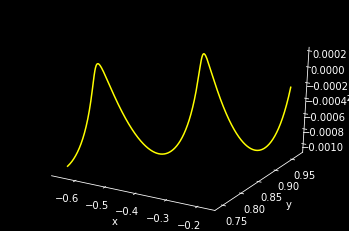

In [19]:
# trajectory
plt.style.use('dark_background')
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.grid(False)
ax.plot3D(x, y, z, 'yellow')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# make the panes black
ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 1.0))

5.94862345010749e-16


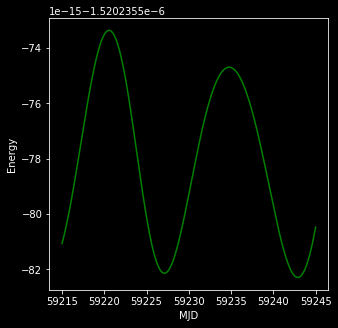

In [20]:
# energy
plt.style.use('dark_background')
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)
plt.plot(MJD, Energy, 'green')
ax.set_xlabel('MJD')
ax.set_ylabel('Energy')

print(Energy[-1]-Energy[0])